# CFM 301 Data Assignment 1 Q2b

Jeongseop Yi (j22yi / 20727267)

In [9]:
import pandas as pd
from pandasql import sqldf
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import linear_model
import statsmodels.api as sm

In [10]:
amzn_data = pd.read_csv("../csv/amazon.csv")
amzn_data.columns = map(str.lower, amzn_data.columns)

ff_factors = pd.read_csv("../csv/ff_factors.csv")
ff_factors.columns = map(str.lower, ff_factors.columns)

ff_factors["dateff"] = pd.to_datetime(ff_factors["dateff"], format='%Y%m%d')
ff_factors["yyyymm"] = ff_factors.dateff.dt.year*100 + ff_factors.dateff.dt.month
ff_factors["monthid"] = (ff_factors.dateff.dt.year-2000)*12 + ff_factors.dateff.dt.month

amzn_data["date"] = pd.to_datetime(amzn_data["date"], format='%Y%m%d')
amzn_data["yyyymm"] = amzn_data.date.dt.year*100 + amzn_data.date.dt.month
amzn_data["monthid"] = (amzn_data.date.dt.year-2000)*12 + amzn_data.date.dt.month

In [11]:
ret_matrix = pd.merge(amzn_data, ff_factors, on="monthid")
ret_matrix["xret"] = ret_matrix["ret"] - ret_matrix["rf"]
ret_matrix["xvwretd"] = ret_matrix["vwretd"] - ret_matrix["rf"]

In [12]:
OLS_data = {'permno':[], 'date':[], 'yyyymm':[], 'monthid':[], 'alpha': [], 'beta': [], 't-alpha': [], 't-beta':[]}

for x in range(61, len(ret_matrix.index) + 1):
    cur_ret = pd.DataFrame(ret_matrix[x-60:x])
    mrkt_ret = cur_ret['xvwretd']
    excess_ret = cur_ret['xret']
    k = sm.add_constant(mrkt_ret)
    model = sm.OLS(excess_ret, k).fit()

    OLS_data['permno'].append(cur_ret['permno'].iloc[0])
    OLS_data['date'].append(cur_ret['date'].iloc[59])
    OLS_data['yyyymm'].append(cur_ret['yyyymm_x'].iloc[59])
    OLS_data['monthid'].append(cur_ret['monthid'].iloc[59])
    OLS_data['beta'].append(model.params['xvwretd'])
    OLS_data['alpha'].append(model.params['const'])
    OLS_data['t-beta'].append(model.tvalues['xvwretd'])
    OLS_data['t-alpha'].append(model.tvalues['const'])

OLS_data = pd.DataFrame(OLS_data)

In [13]:
print(OLS_data[['yyyymm', 'beta', 'alpha', 't-beta', 't-alpha']])

     yyyymm      beta     alpha    t-beta   t-alpha
0    200501  2.504419  0.015000  6.028005  0.737561
1    200502  2.467856  0.011029  5.805938  0.530645
2    200503  2.527067  0.014066  5.951156  0.682236
3    200504  2.512836  0.014532  5.853042  0.705595
4    200505  2.499904  0.014934  5.817080  0.726104
..      ...       ...       ...       ...       ...
199  202108  1.061369  0.013630  5.504953  1.530245
200  202109  1.077247  0.011864  5.711296  1.352160
201  202110  1.041129  0.012206  5.543502  1.377650
202  202111  1.052589  0.014574  5.715452  1.685608
203  202112  1.037916  0.013706  5.547865  1.556011

[204 rows x 5 columns]


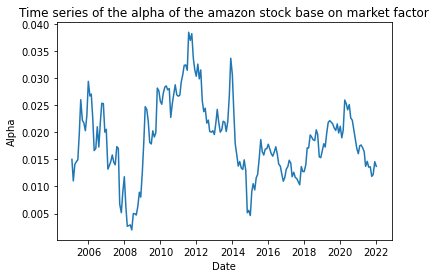

In [14]:
# create the time series plot
alpha_series = sns.lineplot(x = "date", y = "alpha",
             data = OLS_data)
plt.xlabel("Date")
plt.ylabel("Alpha")
plt.title("Time series of the alpha of the amazon stock base on market factor")
plt.show(alpha_series)

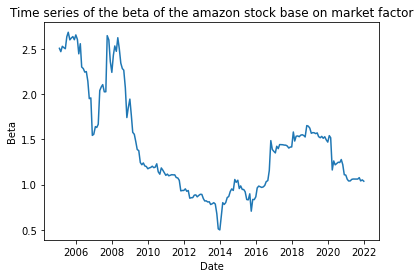

In [15]:
beta_series = sns.lineplot(x = "date", y = "beta",
             data = OLS_data)
plt.xlabel("Date")
plt.ylabel("Beta")
plt.title("Time series of the beta of the amazon stock base on market factor")
plt.show(beta_series)

In [16]:
OLS_data = pd.DataFrame(OLS_data).sort_values(['yyyymm'])
with pd.ExcelWriter("../xlsx/2b3b.xlsx", mode='a', engine="openpyxl", if_sheet_exists='replace') as writer:
    OLS_data.to_excel(writer, sheet_name="2b")